In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

## Data preparation

In [2]:
df = pd.read_csv("data/Blue and fin whales Southern California 2014-2015 - Fastloc GPS data.csv")

In [3]:
df = df[df['manually-marked-outlier'].isna()] # 19 outliers
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
whales = []
for id in df['individual-local-identifier'].unique():
    whales.append(df[df['individual-local-identifier']==id][['timestamp','location-lat','location-long']])

### Analyse timestamp

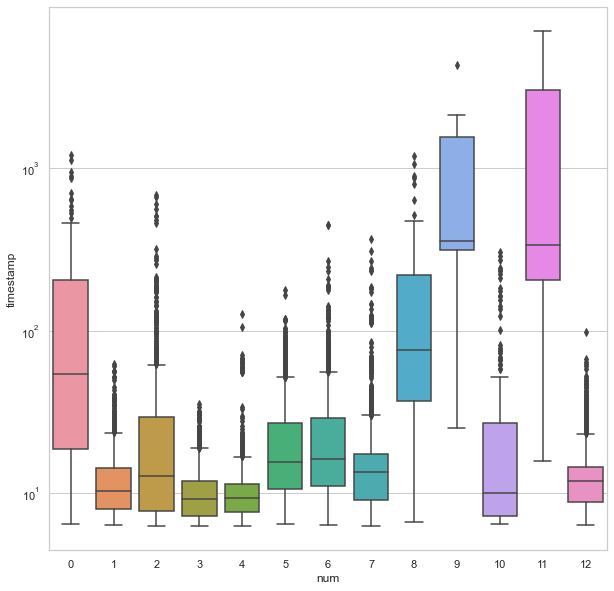

In [5]:
diffs = []
for i in range(len(whales)):
    diff = whales[i]['timestamp'].diff()/np.timedelta64(1, 'm')
    diff = diff.to_frame()
    diff['num'] = i
    diffs.append(diff)
diffs = pd.concat(diffs)
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
bx = sns.boxplot(data = diffs, x="num", y="timestamp")
bx.set_yscale("log")

In [165]:
interval = '20min'
datas = []
for whale in whales:
    data = whale.set_index('timestamp').resample(interval).mean().interpolate(method='polynomial',order=2)
    # data['timestamp'] = data['timestamp']/np.timedelta64(1, 's')
    data['daycos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('D').to_timestamp().timestamp())*2*np.pi/86400), axis=1)
    data['yearcos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('Y').to_timestamp().timestamp())*2*np.pi/31536000), axis=1)
    data[['location-lat','location-long']] = data[['location-lat','location-long']].diff()
    data['pre-location-lat'] = data['location-lat'].shift(1)
    data['pre-location-long'] = data['location-long'].shift(1)
    data = data.iloc[2:]
    datas.append(data)

In [ ]:
data = datas[4]
i_split = int(len(data)*0.8)
X = data[['daycos','yearcos','pre-location-lat','pre-location-long']]
y = data[['location-lat','location-long']]
X_train = X[:i_split]
X_test = X[i_split:]
y_train = y[:i_split]
y_test = y[i_split:]

## Prediction with Linear Regression

In [267]:
reg = LinearRegression().fit(X_train,y_train)

In [268]:
print(reg.coef_)
print(reg.intercept_)

[[ 1.46420949e-04 -6.87106952e-03 -3.78007282e-07  7.28473212e-01
  -3.51440159e-02]
 [-6.63151019e-05 -1.16097542e-02 -9.86116255e-07 -1.32896811e-01
   6.53813123e-01]]
[-0.00705858 -0.01116708]


In [269]:
pred = reg.predict(X_test)

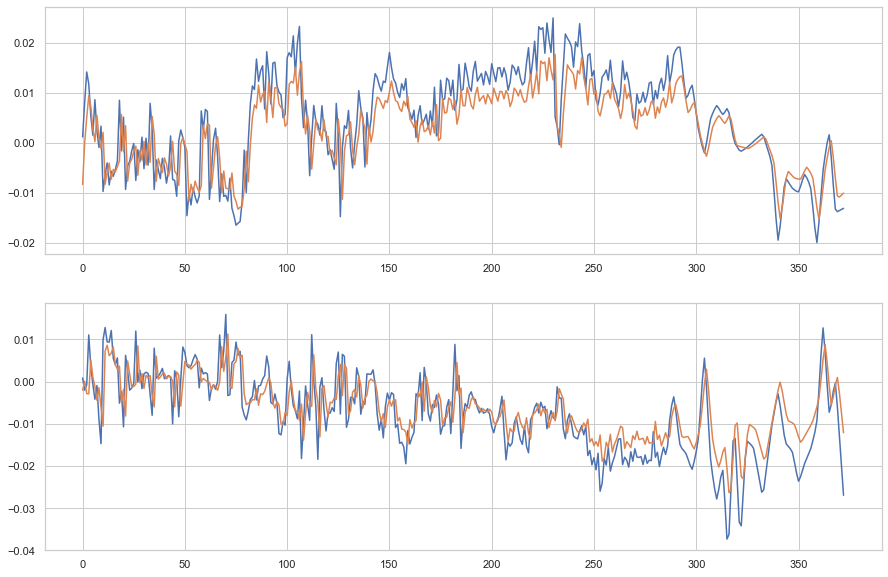

In [270]:
a=0
b=len(y_test)
points = list(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,y_test['location-lat'][a:b])
plt.plot(points,pred[a:b,0])
plt.subplot(2,1,2)
plt.plot(points,y_test['location-long'][a:b])
plt.plot(points,pred[a:b,1])

In [271]:
mean_squared_error(pred,y_test)

3.0028836714581627e-05

In [301]:
reg.score(X_test,y_test)

0.6721914908834055

## Prediction with AdaBoost

In [218]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [322]:
rng = 0
base = DecisionTreeRegressor(max_depth=5)
adareg_lat = AdaBoostRegressor(base,n_estimators=10,random_state = rng)
adareg_long = AdaBoostRegressor(base,n_estimators=10,random_state = rng)
y_train_lat = y_train['location-lat']
y_train_long = y_train['location-long']
adareg_lat.fit(X_train,y_train_lat)
adareg_long.fit(X_train,y_train_long)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  n_estimators=10, random_state=0)

In [323]:
pred_lat = adareg_lat.predict(X_test)
pred_long = adareg_long.predict(X_test)

In [324]:
pred = np.concatenate((pred_lat[:,np.newaxis],pred_long[:,np.newaxis]),axis=1)

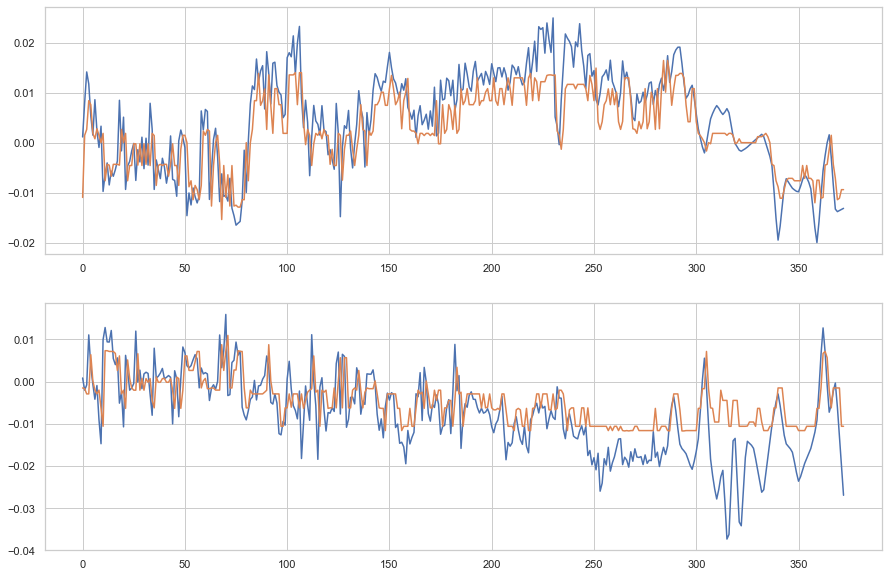

In [325]:
a=0
b=len(y_test)
points = list(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,y_test['location-lat'][a:b])
plt.plot(points,pred[a:b,0])
plt.subplot(2,1,2)
plt.plot(points,y_test['location-long'][a:b])
plt.plot(points,pred[a:b,1])

In [326]:
mean_squared_error(pred,y_test)

4.3748096773608904e-05

In [327]:
print(adareg_lat.score(X_test,y_test['location-lat']))
print(adareg_long.score(X_test,y_test['location-long']))

0.6621907377697631
0.37520907036595974
